In [ ]:
import pandas as pd
import requests
import xml.etree.ElementTree as ET
import math
import time
import ast
import string
import pickle
import os.path
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load the CSV file (adjust the file path to match your setup)
file_path = "/content/drive/MyDrive/boardgames_ranks.csv"  # Update the path if needed
df_boardgames = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df_boardgames.head())

# Sort by Bayesian average and extract top 10 games
df_sorted = df_boardgames.sort_values(by="bayesaverage", ascending=False).head(10)

# Save the Top 10 Games to a new CSV
top_10_path = "/content/drive/My Drive/top_10_boardgames.csv"
df_sorted.to_csv(top_10_path, index=False)

# Display the Top 10 games
print("Top 10 Games:")
print(df_sorted)


       id                               name  yearpublished  rank  \
0  224517                  Brass: Birmingham           2018     1   
1  161936          Pandemic Legacy: Season 1           2015     2   
2  342942                           Ark Nova           2021     3   
3  174430                         Gloomhaven           2017     4   
4  233078  Twilight Imperium: Fourth Edition           2017     5   

   bayesaverage  average  usersrated  is_expansion  abstracts_rank  cgs_rank  \
0       8.40655  8.58340       50192             0             NaN       NaN   
1       8.37032  8.52021       54987             0             NaN       NaN   
2       8.34254  8.53492       49741             0             NaN       NaN   
3       8.33433  8.57124       64118             0             NaN       NaN   
4       8.23113  8.58243       25403             0             NaN       NaN   

   childrensgames_rank  familygames_rank  partygames_rank  strategygames_rank  \
0                  NaN 

In [ ]:
df_sorted[:10]

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
105075,247030,Terraforming Mars: Prelude,2018,0,8.40978,8.84707,16106,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,224517,Brass: Birmingham,2018,1,8.40655,8.58340,50192,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,161936,Pandemic Legacy: Season 1,2015,2,8.37032,8.52021,54987,0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN
2,342942,Ark Nova,2021,3,8.34254,8.53492,49741,0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
3,174430,Gloomhaven,2017,4,8.33433,8.57124,64118,0,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN
138518,363622,The Castles of Burgundy: Special Edition,2023,0,8.31470,9.15260,7886,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,233078,Twilight Imperium: Fourth Edition,2017,5,8.23113,8.58243,25403,0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN
5,316554,Dune: Imperium,2020,6,8.22822,8.42701,50463,0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
6,167791,Terraforming Mars,2016,7,8.20412,8.35197,104174,0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN
7,115746,War of the Ring: Second Edition,2011,8,8.19200,8.54693,22718,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0


In [ ]:
bg10 = df_boardgames[:10]

In [ ]:
import os
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import math
import time
import numpy as np
from requests.exceptions import ChunkedEncodingError, RequestException
'''
# Function to download game comments with increased pagination & retry logic
def download_game_comments(game_id, max_pages=30, max_retries=5):
    base_url = f"https://boardgamegeek.com/xmlapi2/thing?id={game_id}&comments=1"
    comments = []

    print(f"🔄 Fetching comments for Game ID: {game_id}")

    try:
        # Initial API request to get total number of comments
        response = requests.get(base_url, timeout=15)
        response.raise_for_status()
        root = ET.fromstring(response.content)

        # Extract the total number of comments
        comments_element = root.find(".//comments")
        if comments_element is None:
            print(f"⚠️ No comments found for game ID: {game_id}")
            return pd.DataFrame()

        total_comments = int(comments_element.attrib['totalitems'])
        total_pages = min(math.ceil(total_comments / 100), max_pages)  # Increased max_pages

        print(f"✅ Found {total_comments} comments. Fetching up to {total_pages} pages.")

        for page in range(1, total_pages + 1):
            url = f"{base_url}&page={page}"

            for attempt in range(max_retries):
                try:
                    response = requests.get(url, timeout=15)
                    response.raise_for_status()
                    page_root = ET.fromstring(response.content)

                    # Parse comments
                    for comment in page_root.findall(".//comment"):
                        comment_data = {
                            "username": comment.attrib.get("username", ""),
                            "rating": comment.attrib.get("rating", None),
                            "comment": comment.attrib.get("value", ""),
                            "game_id": game_id,
                        }
                        comments.append(comment_data)

                    print(f"✅ Page {page}/{total_pages} downloaded. Total: {len(comments)} comments.")
                    time.sleep(1.5)  # Prevent rate-limiting
                    break  # Exit retry loop if successful

                except (ChunkedEncodingError, RequestException) as e:
                    print(f"⚠️ Retry {attempt + 1} failed for page {page}: {e}")
                    time.sleep(2 ** attempt)  # Exponential backoff

            else:
                print(f"❌ Skipping page {page} after {max_retries} failed attempts.")
                break  # Stop requesting further pages if repeated failures occur

    except requests.exceptions.RequestException as e:
        print(f"❌ Error fetching comments: {e}")
    except ET.ParseError as e:
        print(f"❌ XML Parsing Error: {e}")

    return pd.DataFrame(comments)


# File path in Google Drive
file_path = '/content/drive/My Drive/boardgames_comments.csv'

# Load or initialize DataFrame
if os.path.isfile(file_path):
    df_comments = pd.read_csv(file_path)
    print("📂 Loaded existing comments.")
else:
    df_comments = pd.DataFrame()
    print("✅ Starting fresh download.")

# Split the dataset into smaller batches (e.g., 3 games per batch)
batch_size = 3
batches = np.array_split(bg10, np.ceil(len(bg10) / batch_size))

# Track failed games
failed_games = []

# Process each batch
for batch_index, batch in enumerate(batches):
    print(f"🔄 Processing batch {batch_index + 1}/{len(batches)}...")

    for _, boardgame in batch.iterrows():
        print(f"🔄 Downloading comments for {boardgame['name']} (ID: {boardgame['id']})")

        try:
            df_game_comments = download_game_comments(boardgame['id'], max_pages=50)  # Increase pages to 50

            if not df_game_comments.empty:
                df_comments = pd.concat([df_comments, df_game_comments], ignore_index=True)

        except Exception as e:
            print(f"⚠️ Failed to process {boardgame['name']} (ID: {boardgame['id']}): {e}")
            failed_games.append(boardgame)

    # Save progress after processing the batch
    df_comments.to_csv(file_path, index=False)
    print(f"✅ Batch {batch_index + 1} saved. Total comments: {len(df_comments)}")

# Retry failed games
if failed_games:
    print(f"🔄 Retrying {len(failed_games)} failed games...")
    for boardgame in failed_games:
        try:
            df_game_comments = download_game_comments(boardgame['id'], max_pages=50)
            if not df_game_comments.empty:
                df_comments = pd.concat([df_comments, df_game_comments], ignore_index=True)
        except Exception as e:
            print(f"❌ Final failure for {boardgame['name']} (ID: {boardgame['id']}): {e}")

    # Save after retries
    df_comments.to_csv(file_path, index=False)

print(f"🎉 All batches processed and saved to Google Drive: {file_path}") '''


'\n# Function to download game comments with increased pagination & retry logic\ndef download_game_comments(game_id, max_pages=30, max_retries=5):\n    base_url = f"https://boardgamegeek.com/xmlapi2/thing?id={game_id}&comments=1"\n    comments = []\n\n    print(f"🔄 Fetching comments for Game ID: {game_id}")\n\n    try:\n        # Initial API request to get total number of comments\n        response = requests.get(base_url, timeout=15)\n        response.raise_for_status()\n        root = ET.fromstring(response.content)\n\n        # Extract the total number of comments\n        comments_element = root.find(".//comments")\n        if comments_element is None:\n            print(f"⚠️ No comments found for game ID: {game_id}")\n            return pd.DataFrame()\n\n        total_comments = int(comments_element.attrib[\'totalitems\'])\n        total_pages = min(math.ceil(total_comments / 100), max_pages)  # Increased max_pages\n\n        print(f"✅ Found {total_comments} comments. Fetching up 

In [ ]:
# File path where the CSV is saved
file_path = "/content/drive/My Drive/boardgames_comments.csv"

# Read the CSV file
df_comments = pd.read_csv(file_path)

# Display the first few rows
print(df_comments.head())

          username  rating                                            comment  \
0            07734    10.0                                               Main   
1  1 Family Meeple     NaN  SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...   
2           13inha     NaN                                                  G   
3             1bez    10.0  Great game, full controllo of your strategy th...   
4             1x0r     8.5                                      Location: MSK   

   game_id  
0   224517  
1   224517  
2   224517  
3   224517  
4   224517  


In [ ]:
df_comments.rename(columns={'comment': 'value'}, inplace=True)


In [ ]:
df_comments

,username,rating,value,game_id
0,07734,10.0,Main,224517
1,1 Family Meeple,NaN,SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...,224517
2,13inha,NaN,G,224517
3,1bez,10.0,"Great game, full controllo of your strategy th...",224517
4,1x0r,8.5,Location: MSK,224517
...,...,...,...,...
52657,Melerune,9.0,Love this game! Haven't explored all of this g...,162886
52658,Melibabe,NaN,1,162886
52659,Melkata,10.0,"Amazing game, with huge replayability. Have pl...",162886
52660,Melkhor,10.0,The undisputed king of my boardgame collection...,162886


In [ ]:
import logging


logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

logger = logging.getLogger('comment_cleaning')


In [ ]:
!pip install langid
from langid.langid import LanguageIdentifier, model
import pandas as pd




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=78907cff0dcd1e37a507508a4c73ff99dc16733589f2e4d713974ab2c74d1787
  Stored in directory: /root/.cache/pip/wheels/32/6a/b6/b7eb43a6ad55b139c15c5daa29f3707659cfa6944d3c696f5b
Successfully built langid


In [ ]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

def clean_comments_df(df_comments: pd.DataFrame) -> pd.DataFrame:
    """
    This function classifies the language of comments from a given DataFrame.

    Args:
        df_comments: A pandas DataFrame containing at least one column with comments to be classified.
                     The column should be named 'value'.

    Returns:
        df_comments: The original DataFrame with additional 'LANGUAGE' and 'PROBABILITY' columns.
    """
    try:

        df_comments['value'] = df_comments['value'].fillna('').astype(str)


        df_comments[['LANGUAGE', 'PROBABILITY']] = df_comments['value'].apply(
            lambda x: pd.Series(identifier.classify(x))
        )

        print("Language classification completed.")


        print(df_comments.head())

        return df_comments

    except Exception as e:
        logger.error(f"Error: {e}")
        return df_comments


In [ ]:
cleaned_df_comments = clean_comments_df(df_comments)
cleaned_df_comments[:25]

Language classification completed.
          username  rating                                              value  \
0            07734    10.0                                               Main   
1  1 Family Meeple     NaN  SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...   
2           13inha     NaN                                                  G   
3             1bez    10.0  Great game, full controllo of your strategy th...   
4             1x0r     8.5                                      Location: MSK   

   game_id LANGUAGE  PROBABILITY  
0   224517       en     0.169462  
1   224517       en     1.000000  
2   224517       en     0.169462  
3   224517       en     1.000000  
4   224517       en     0.169462  


,username,rating,value,game_id,LANGUAGE,PROBABILITY
0,07734,10.0,Main,224517,en,0.169462
1,1 Family Meeple,NaN,SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...,224517,en,1.000000
2,13inha,NaN,G,224517,en,0.169462
3,1bez,10.0,"Great game, full controllo of your strategy th...",224517,en,1.000000
4,1x0r,8.5,Location: MSK,224517,en,0.169462
5,2bit,7.5,"Very clever game, enjoyable overall. Plus poi...",224517,en,1.000000
6,2d20,9.0,Brilliant! Fits right into my wheelhouse all ...,224517,en,1.000000
7,35tango,10.0,Absolutely brilliant! I never played the orig...,224517,en,1.000000
8,4characters,4.0,I prefer old school Brass or AoI. I do like th...,224517,en,1.000000
9,4ndroid,8.0,Sold,224517,en,0.169462


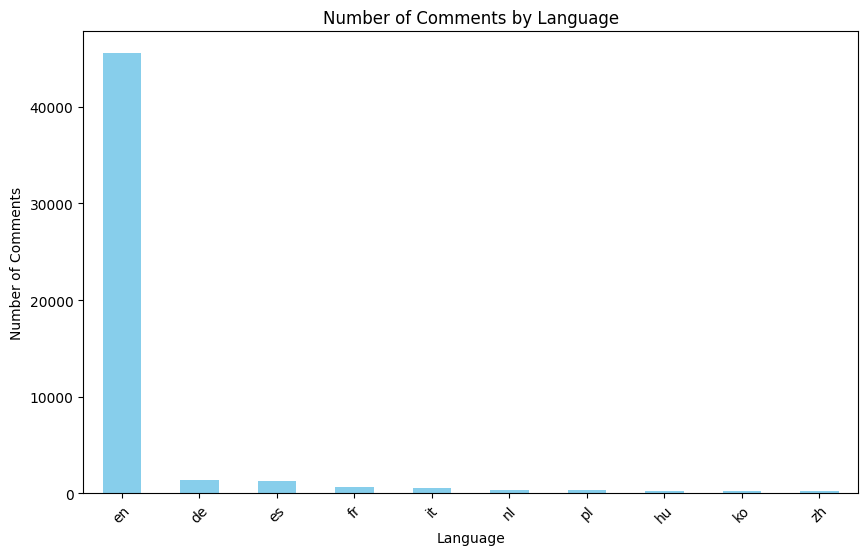

In [ ]:
def plot_language_distribution(df_comments: pd.DataFrame, top_n: int = 10):
    """
    This function plots the distribution of comments by language.

    Args:
        df_comments: A pandas DataFrame containing the 'LANGUAGE' column.
    """
    try:

        if 'LANGUAGE' not in df_comments.columns:
            print("LANGUAGE column not found in DataFrame.")
            return


        language_counts = df_comments['LANGUAGE'].value_counts().head(top_n)

        # Plotting the distribution
        plt.figure(figsize=(10, 6))
        language_counts.plot(kind='bar', color='skyblue')
        plt.title('Number of Comments by Language')
        plt.xlabel('Language')
        plt.ylabel('Number of Comments')
        plt.xticks(rotation=45)
        plt.show()

    except Exception as e:
        print(f"Error while plotting: {e}")


# Plot the distribution of languages
plot_language_distribution(cleaned_df_comments, top_n=10)


In [ ]:
total_comments = cleaned_df_comments.shape[0]
# Count comments that are not in English
non_english_count = cleaned_df_comments[cleaned_df_comments['LANGUAGE'] != 'en'].shape[0]

# Calculate percentage of non-English comments
non_english_percentage = (non_english_count / total_comments) * 100 if total_comments > 0 else 0
print(f"Total comments: {total_comments}")
print(f"Number of non-English comments: {non_english_count}")
print(f"Percentage of non-English comments: {non_english_percentage:.2f}%")


Total comments: 52662
Number of non-English comments: 7138
Percentage of non-English comments: 13.55%


In [ ]:
# Filter out English commen
comments_df = cleaned_df_comments[cleaned_df_comments['LANGUAGE'] == 'en']
comments_df.rename(columns={'game_id': 'boardgame_id'}, inplace=True)


<ipython-input-20-4ca31e9639b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_df.rename(columns={'game_id': 'boardgame_id'}, inplace=True)


In [ ]:
comments_df

,username,rating,value,boardgame_id,LANGUAGE,PROBABILITY
0,07734,10.0,Main,224517,en,0.169462
1,1 Family Meeple,NaN,SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...,224517,en,1.000000
2,13inha,NaN,G,224517,en,0.169462
3,1bez,10.0,"Great game, full controllo of your strategy th...",224517,en,1.000000
4,1x0r,8.5,Location: MSK,224517,en,0.169462
...,...,...,...,...,...,...
52657,Melerune,9.0,Love this game! Haven't explored all of this g...,162886,en,1.000000
52658,Melibabe,NaN,1,162886,en,0.169462
52659,Melkata,10.0,"Amazing game, with huge replayability. Have pl...",162886,en,1.000000
52660,Melkhor,10.0,The undisputed king of my boardgame collection...,162886,en,1.000000


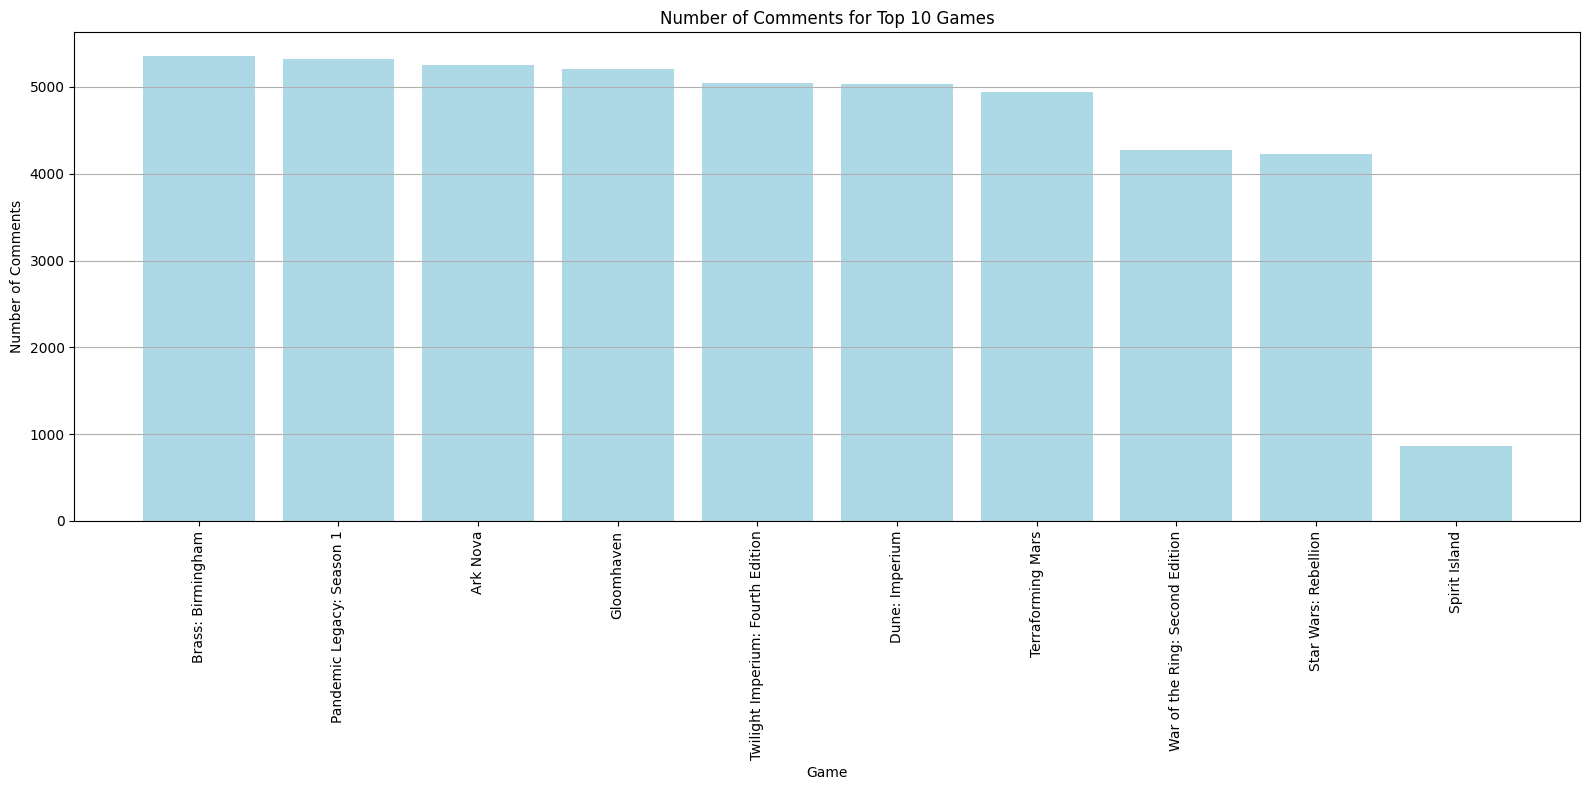

In [ ]:
#  Merging the two DataFrames to associate comments with the top 10 games
merged_df = comments_df.merge(bg10, left_on='boardgame_id', right_on='id', how='inner')

game_comments_count = merged_df['boardgame_id'].value_counts().head(10)
plot_data = merged_df[['boardgame_id', 'name']].drop_duplicates()  # Keep unique boardgame_id and names
plot_data['comment_count'] = game_comments_count.values

plt.figure(figsize=(16, 8))
plt.bar(plot_data['name'], plot_data['comment_count'], color='lightblue')
plt.title('Number of Comments for Top 10 Games')
plt.xlabel('Game')
plt.ylabel('Number of Comments')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


# **Sentiment Analysis of the comments**

In [ ]:
import torch
from transformers import pipeline

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

# Load Sentiment Analysis Model on GPU
sentiment_pipeline = pipeline("sentiment-analysis", model="textattack/bert-base-uncased-SST-2", device=device)

# Confirm the device
print("Using Device:", "GPU" if device == 0 else "CPU")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Using Device: GPU


In [ ]:
from transformers import pipeline

# Load a faster sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", device=0)

print("✅ Model Loaded: Running on GPU 🚀")
print(df_comments.columns)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


✅ Model Loaded: Running on GPU 🚀
Index(['username', 'rating', 'value', 'game_id', 'LANGUAGE', 'PROBABILITY'], dtype='object')


In [ ]:
import torch
from transformers import pipeline

# ✅ Check if GPU is available
device = 0 if torch.cuda.is_available() else -1  # 0 for GPU, -1 for CPU

# ✅ Load the sentiment analysis pipeline with a faster model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=device
)

print(f"✅ Sentiment Model Loaded. Running on: {'GPU' if device == 0 else 'CPU'} 🚀")

# ✅ Process comments in batches instead of one-by-one
batch_size = 32  # Adjust batch size for efficiency

# ✅ Convert comments to a list & truncate long comments (512 tokens max)
comments_list = comments_df['value'].astype(str).tolist()
truncated_comments = [comment[:512] for comment in comments_list]

# ✅ Run sentiment analysis in batches (faster processing)
results = sentiment_pipeline(truncated_comments, batch_size=batch_size)

# ✅ Store results in the DataFrame
comments_df['sentiment_label'] = [res['label'] for res in results]
comments_df['sentiment_score'] = [res['score'] for res in results]

# ✅ Display updated DataFrame
print("✅ Sentiment Analysis Completed! 🎉")
print(comments_df[['value', 'sentiment_label', 'sentiment_score']])


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


✅ Sentiment Model Loaded. Running on: GPU 🚀
✅ Sentiment Analysis Completed! 🎉
                                                   value sentiment_label  \
0                                                   Main         neutral   
1      SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...         neutral   
2                                                      G         neutral   
3      Great game, full controllo of your strategy th...        positive   
4                                          Location: MSK         neutral   
...                                                  ...             ...   
52657  Love this game! Haven't explored all of this g...        positive   
52658                                                  1         neutral   
52659  Amazing game, with huge replayability. Have pl...        positive   
52660  The undisputed king of my boardgame collection...        positive   
52661                                              OA1-3         neutral   

       se

<ipython-input-25-48e6c7b3debe>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_df['sentiment_label'] = [res['label'] for res in results]
<ipython-input-25-48e6c7b3debe>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_df['sentiment_score'] = [res['score'] for res in results]


In [ ]:
game_id = 115746
# Filter the comments DataFrame for  specific game ID
game_df = comments_df[comments_df['boardgame_id'] == game_id]
print(game_df[['value', 'sentiment_label', 'sentiment_score']])

                                                   value sentiment_label  \
7000   -0,5 for too soft plastic figures.  They are d...        negative   
7001                             Organized; FoldedSpace.         neutral   
7002                         BGG Spring 2019 VFM (trade)         neutral   
7003   Great strategy game but slightly biased agains...        negative   
7004   One of the best thematic implementations... yo...        positive   
...                                                  ...             ...   
42655  (first edition comments) Dripping with theme, ...        positive   
42657  War of the Ring is a highly engaging and emoti...        positive   
42659                              #tolearn #game-group          neutral   
42660                    Too heavy for a Thematic bg....        negative   
42661  Prior to 2020: 2 plays  This is one of the har...        negative   

       sentiment_score  
7000          0.923838  
7001          0.819330  
7002        

In [ ]:
!pip install spacy
!pip install spacy vaderSentiment
import spacy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
comments_df = pd.DataFrame(comments_df)

In [ ]:
import nltk
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

# ✅ Download VADER lexicon
nltk.download('vader_lexicon')

# ✅ Load NLP Model (SpaCy) for POS tagging
nlp = spacy.load("en_core_web_sm")

# ✅ Load Sentiment Analyzer (VADER)
sentiment_analyzer = SentimentIntensityAnalyzer()

# ✅ Function to extract aspects from comments
def extract_aspects(comment):
    doc = nlp(comment)
    aspects = {"positive": [], "negative": []}

    for token in doc:
        if token.pos_ in ["NOUN", "ADJ"]:  # Include nouns and adjectives as aspects
            sentiment_score = sentiment_analyzer.polarity_scores(token.text)['compound']
            if sentiment_score >= 0.05:
                aspects["positive"].append(token.text.lower())  # Use lower case for uniformity
            elif sentiment_score <= -0.05:
                aspects["negative"].append(token.text.lower())

    return aspects

def get_top_aspects_by_sentiment(df):
    all_aspects = {
        "positive": [],
        "negative": []
    }

    # Collect aspects by boardgame_id
    for _, row in df.iterrows():
        aspects = extract_aspects(row['value'])
        all_aspects["positive"].extend(aspects["positive"])
        all_aspects["negative"].extend(aspects["negative"])

    # Count and rank aspects
    positive_counts = Counter(all_aspects["positive"])
    negative_counts = Counter(all_aspects["negative"])

    top_positive_aspects = [aspect for aspect, count in positive_counts.most_common(10)]
    top_negative_aspects = [aspect for aspect, count in negative_counts.most_common(10)]

    return top_positive_aspects, top_negative_aspects


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
from collections import Counter
# Process the DataFrame to get top aspects by sentiment
results = {}
for boardgame_id in comments_df['boardgame_id'].unique():
    subset_df = comments_df[comments_df['boardgame_id'] == boardgame_id]
    top_positive, top_negative = get_top_aspects_by_sentiment(subset_df)
    results[boardgame_id] = {
        "top_positive": top_positive,
        "top_negative": top_negative
    }


In [ ]:
results_df = pd.DataFrame(results)


In [ ]:
results_df = results_df.T.reset_index()  # Transpose the DataFrame and reset the index
results_df.rename(columns={"index": "boardgame_id"}, inplace=True)  # Rename the index column to 'boardgame_id'

print(results_df.head())  # Check the new DataFrame structure


   boardgame_id                                       top_positive  \
0        224517  [good, great, fun, original, play, best, bette...   
1        161936  [great, fun, good, best, play, amazing, intere...   
2        342942  [good, great, fun, play, plays, luck, best, in...   
3        174430  [great, fun, good, best, play, interesting, am...   
4        233078  [great, fun, good, best, play, better, friends...   

                                        top_negative  
0  [hard, difficult, bad, demand, boring, tense, ...  
1  [bad, difficult, difficulty, hard, risk, borin...  
2  [bad, hard, negative, difficult, problem, frus...  
3  [combat, hard, repetitive, bad, enemies, diffi...  
4  [combat, hard, bad, war, battles, difficult, p...  


In [ ]:
results_df

,boardgame_id,top_positive,top_negative
0,224517,"[good, great, fun, original, play, best, bette...","[hard, difficult, bad, demand, boring, tense, ..."
1,161936,"[great, fun, good, best, play, amazing, intere...","[bad, difficult, difficulty, hard, risk, borin..."
2,342942,"[good, great, fun, play, plays, luck, best, in...","[bad, hard, negative, difficult, problem, frus..."
3,174430,"[great, fun, good, best, play, interesting, am...","[combat, hard, repetitive, bad, enemies, diffi..."
4,233078,"[great, fun, good, best, play, better, friends...","[combat, hard, bad, war, battles, difficult, p..."
5,316554,"[good, great, fun, play, best, luck, interesti...","[combat, conflict, bad, battle, tense, tension..."
6,167791,"[good, great, fun, play, best, better, plays, ...","[bad, hard, poor, boring, problem, low, diffic..."
7,115746,"[great, best, good, play, fun, fan, amazing, p...","[war, combat, hard, tense, difficult, bad, bat..."
8,187645,"[great, fun, good, play, best, fan, original, ...","[combat, wars, rebels, rebel, rebellion, war, ..."
9,162886,"[great, fun, good, best, play, spirit, plays, ...","[difficulty, difficult, hard, adversaries, bad..."


# **Abspect based sentiment analysis**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load ABSA model and tokenizer
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

# Load traditional sentiment analysis model
sentiment_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_pipeline = pipeline("sentiment-analysis", model=sentiment_model_path, tokenizer=sentiment_model_path)

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
aspects = ['LUCK', 'BOOKKEEPING', 'DOWNTIME', 'INTERACTION', 'BASH THE LEADER','COMPLICATED', 'COMPLEX']

# Function to extract aspects from comments
def idx_extractor(string, labels):
    string = string.lower()
    for l in labels:
        if l.lower() in string:
            return l
    return None
comments_df.loc[:, 'ASPECT'] = comments_df['value'].apply(lambda x: idx_extractor(x, aspects))

In [ ]:
import torch.nn.functional as F

# ABSA function for aspect sentiment analysis
def analyze_aspect_sentiment(sentence, aspect):
    inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt", truncation=True, max_length=512)
    outputs = absa_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1).detach().numpy()[0]
    sentiment_scores = {label: prob for prob, label in zip(probs, ["negative", "neutral", "positive"])}
    return sentiment_scores

In [ ]:
def analyze_aspects_for_comments_batch(comments, aspects):
    """
    Analyze sentiment for multiple comments in a batch.
    :param comments: List of comments to process.
    :param aspects: List of aspects to analyze.
    :return: List of dictionaries with aspect sentiments for each comment.
    """
    batch_aspect_sentiments = []

    for comment in comments:
        aspect_sentiments = {}
        for aspect in aspects:
            if aspect.lower() in comment.lower():
                sentiment = analyze_aspect_sentiment(comment, aspect)  # Perform ABSA analysis
                aspect_sentiments[aspect] = sentiment
        batch_aspect_sentiments.append(aspect_sentiments)

    return batch_aspect_sentiments


In [ ]:
'''# Function to analyze sentiment for each aspect in a comment
def analyze_aspects_for_comment(comment, aspects):
    aspect_sentiments = {}
    for aspect in aspects:
        if aspect.lower() in comment.lower():
            sentiment = analyze_aspect_sentiment(comment, aspect)
            aspect_sentiments[aspect] = sentiment
    return aspect_sentiments'''

'# Function to analyze sentiment for each aspect in a comment\ndef analyze_aspects_for_comment(comment, aspects):\n    aspect_sentiments = {}\n    for aspect in aspects:\n        if aspect.lower() in comment.lower():\n            sentiment = analyze_aspect_sentiment(comment, aspect)\n            aspect_sentiments[aspect] = sentiment\n    return aspect_sentiments'

In [ ]:
'''comments_df['aspect_sentiments'] = comments_df.apply(
    lambda row: analyze_aspects_for_comment(row['value'], aspects), axis=1
)'''

"comments_df['aspect_sentiments'] = comments_df.apply(\n    lambda row: analyze_aspects_for_comment(row['value'], aspects), axis=1\n)"

In [ ]:
# Function to process comments in batches
def process_comments_in_batches(comments_df, aspects, batch_size=100):
    """
    Process comments in batches to analyze aspects and their sentiments.
    :param comments_df: DataFrame containing the comments in the 'value' column.
    :param aspects: List of aspects to analyze.
    :param batch_size: Number of rows to process per batch.
    :return: Updated DataFrame with an 'aspect_sentiments' column.
    """
    comments_df = comments_df.copy()  # Prevent modifying original DataFrame
    aspect_sentiments_results = []  # Store batch results

    for start_idx in range(0, len(comments_df), batch_size):
        end_idx = min(start_idx + batch_size, len(comments_df))
        batch = comments_df.iloc[start_idx:end_idx]

        # Analyze sentiment for the batch
        aspect_sentiments_batch = analyze_aspects_for_comments_batch(
            batch['value'].tolist(), aspects
        )

        # Append batch results
        aspect_sentiments_results.extend(aspect_sentiments_batch)

    # Assign the entire result list at once (avoids index mismatch)
    comments_df['aspect_sentiments'] = aspect_sentiments_results

    return comments_df

# Apply batch processing
comments_df = process_comments_in_batches(comments_df, aspects, batch_size=256)


In [ ]:

print(comments_df.columns)
print(comments_df.columns.tolist())  # Shows all column names
comments_df.head()

Index(['username', 'rating', 'value', 'boardgame_id', 'LANGUAGE',
       'PROBABILITY', 'sentiment_label', 'sentiment_score', 'ASPECT',
       'aspect_sentiments'],
      dtype='object')
['username', 'rating', 'value', 'boardgame_id', 'LANGUAGE', 'PROBABILITY', 'sentiment_label', 'sentiment_score', 'ASPECT', 'aspect_sentiments']


,username,rating,value,boardgame_id,LANGUAGE,PROBABILITY,sentiment_label,sentiment_score,ASPECT,aspect_sentiments
0,07734,10.0,Main,224517,en,0.169462,neutral,0.598183,None,{}
1,1 Family Meeple,NaN,SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...,224517,en,1.000000,neutral,0.904020,None,{}
2,13inha,NaN,G,224517,en,0.169462,neutral,0.475218,None,{}
3,1bez,10.0,"Great game, full controllo of your strategy th...",224517,en,1.000000,positive,0.894109,None,{}
4,1x0r,8.5,Location: MSK,224517,en,0.169462,neutral,0.890108,None,{}


In [ ]:
print(comments_df['aspect_sentiments'].value_counts())


aspect_sentiments
{}                                                                                                                                                                           41093
{'COMPLEX': {'negative': 0.49700475, 'neutral': 0.4574293, 'positive': 0.045566034}}                                                                                             3
{'COMPLEX': {'negative': 0.8919633, 'neutral': 0.029455174, 'positive': 0.07858145}}                                                                                             3
{'LUCK': {'negative': 0.9872155, 'neutral': 0.006586214, 'positive': 0.0061982255}}                                                                                              2
{'COMPLICATED': {'negative': 0.9045863, 'neutral': 0.016548352, 'positive': 0.07886534}}                                                                                         2
                                                                                       

In [ ]:
print(analyze_aspect_sentiment("This game is fantastic!", "LUCK"))
print(analyze_aspect_sentiment("The mechanics are very well-balanced.", "MECHANICS"))
print(analyze_aspect_sentiment("I love how interactive it is.", "INTERACTION"))


{'negative': 0.015636666, 'neutral': 0.61968905, 'positive': 0.36467427}
{'negative': 0.0011000053, 'neutral': 0.0033962799, 'positive': 0.9955037}
{'negative': 0.0010082275, 'neutral': 0.002636794, 'positive': 0.99635494}


In [ ]:
# Aggregating sentiment results by Game ID and Aspect
def aggregate_aspect_sentiment(comments_df):
    game_aspect_sentiments = defaultdict(lambda: defaultdict(list))

    for _, row in comments_df.iterrows():
        game_id = row['boardgame_id']
        aspect_sentiments = row['aspect_sentiments']

        for aspect, sentiment in aspect_sentiments.items():
            game_aspect_sentiments[game_id][aspect].append(sentiment)

    # Calculate average sentiment for each aspect of each game
    aggregated_results = []
    for game_id, aspects in game_aspect_sentiments.items():
        for aspect, sentiments in aspects.items():
            overall_sentiment_scores = [-s['negative'] + s['positive'] for s in sentiments]
            avg_overall_sentiment_score = sum(overall_sentiment_scores) / len(overall_sentiment_scores)
            aggregated_results.append({
                'game_id': game_id,
                'aspect': aspect,
                'overall_sentiment_score': avg_overall_sentiment_score
            })

    return pd.DataFrame(aggregated_results)


In [ ]:
from collections import defaultdict
aggregated_sentiment_df = aggregate_aspect_sentiment(comments_df)
aggregated_sentiment_df

,game_id,aspect,overall_sentiment_score
0,224517,DOWNTIME,-0.152831
1,224517,INTERACTION,0.804205
2,224517,COMPLEX,-0.159855
3,224517,LUCK,0.008525
4,224517,COMPLICATED,-0.459253
5,161936,COMPLEX,-0.112262
6,161936,LUCK,-0.198350
7,161936,COMPLICATED,-0.317575
8,161936,INTERACTION,0.975588
9,161936,BOOKKEEPING,-0.704486


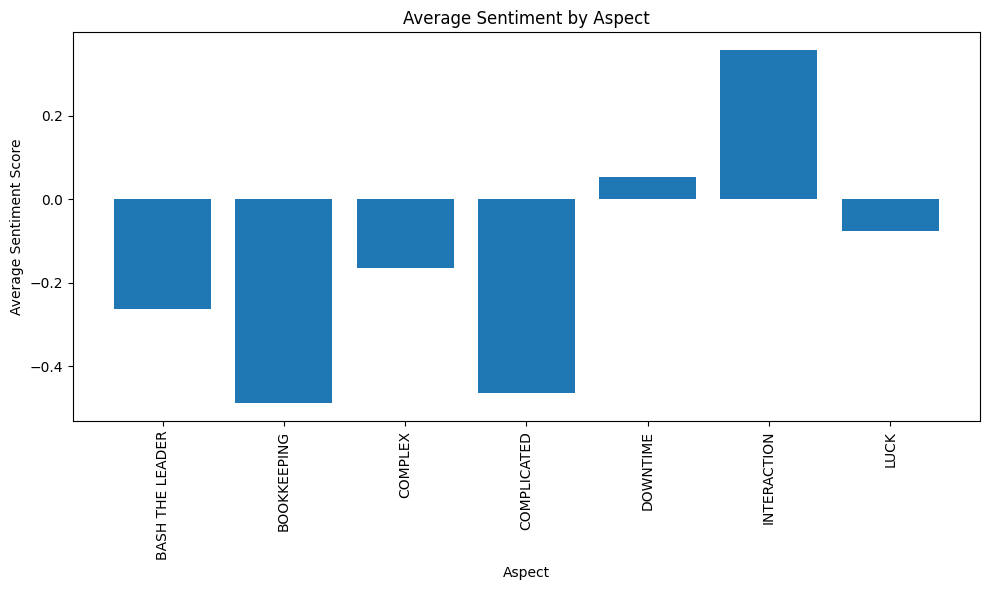

In [ ]:
avg_sentiment = aggregated_sentiment_df.groupby('aspect')['overall_sentiment_score'].mean()

plt.figure(figsize=(10, 6))
plt.bar(avg_sentiment.index, avg_sentiment.values)
plt.xlabel('Aspect')
plt.ylabel('Average Sentiment Score')
_ = plt.title('Average Sentiment by Aspect')
plt.xticks(rotation=90)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
table_df = aggregated_sentiment_df.pivot(index='game_id', columns='aspect', values='overall_sentiment_score')
table_df

aspect,BASH THE LEADER,BOOKKEEPING,COMPLEX,COMPLICATED,DOWNTIME,INTERACTION,LUCK
game_id,,,,,,,
115746,NaN,NaN,-0.359455,-0.558704,0.130616,0.246035,-0.037419
161936,NaN,-0.704486,-0.112262,-0.317575,0.719961,0.975588,-0.198350
162886,NaN,-0.637781,-0.062874,-0.528871,0.303960,0.447259,0.141527
167791,-0.193153,0.011038,-0.198023,-0.437873,-0.524343,-0.235566,-0.023446
174430,NaN,-0.475967,-0.110227,-0.460587,-0.059197,0.100361,-0.104765
187645,NaN,-0.906832,-0.163251,-0.523608,0.284850,0.557191,-0.159391
224517,NaN,NaN,-0.159855,-0.459253,-0.152831,0.804205,0.008525
233078,-0.332175,-0.363805,-0.248086,-0.527748,-0.166143,0.621739,-0.126795
316554,NaN,NaN,-0.013212,-0.139640,0.291078,0.544670,-0.141087


In [ ]:
comments_df.loc[:, 'ASPECT'] = comments_df['value'].apply(lambda x: idx_extractor(x, aspects))

In [ ]:
# Check unique aspects after assignment
print("Unique aspects found in comments:")
print(comments_df['ASPECT'].unique())

Unique aspects found in comments:
[None 'DOWNTIME' 'INTERACTION' 'COMPLEX' 'LUCK' 'COMPLICATED'
 'BOOKKEEPING' 'BASH THE LEADER']


In [ ]:
lcomments_df = print(comments_df[['value', 'ASPECT']])

                                                   value ASPECT
0                                                   Main   None
1      SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...   None
2                                                      G   None
3      Great game, full controllo of your strategy th...   None
4                                          Location: MSK   None
...                                                  ...    ...
52657  Love this game! Haven't explored all of this g...   None
52658                                                  1   None
52659  Amazing game, with huge replayability. Have pl...   None
52660  The undisputed king of my boardgame collection...   None
52661                                              OA1-3   None

[45524 rows x 2 columns]


In [ ]:
print(comments_df.columns)


Index(['username', 'rating', 'value', 'boardgame_id', 'LANGUAGE',
       'PROBABILITY', 'sentiment_label', 'sentiment_score', 'ASPECT',
       'aspect_sentiments'],
      dtype='object')


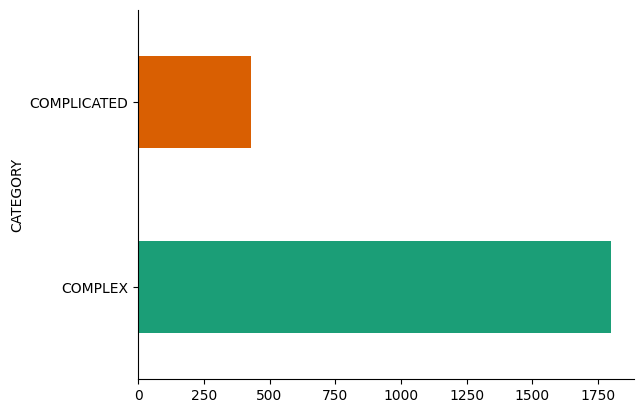

In [ ]:
import seaborn as sns
# Define function to categorize comments
def categorize_comment(comment):
    comment = str(comment).lower()  # Convert to lowercase for case-insensitive matching
    if "complex" in comment:
        return "COMPLEX"
    elif "complicated" in comment:
        return "COMPLICATED"


# Apply function to create CATEGORY column
comments_df['CATEGORY'] = comments_df['value'].apply(categorize_comment)

comments_df.groupby('CATEGORY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

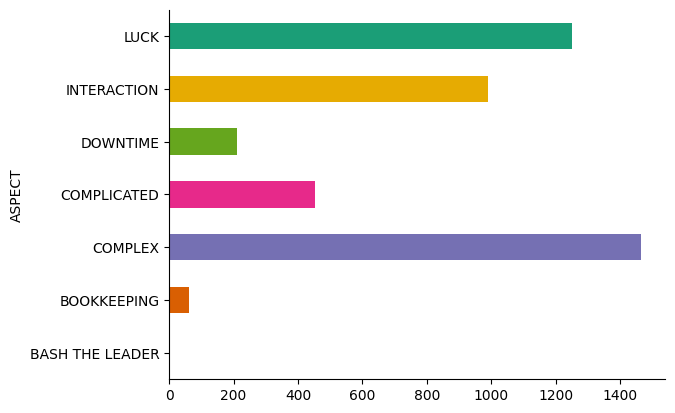

In [ ]:
#aspect
comments_df.groupby('ASPECT').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Filter comments where either ASPECT or CATEGORY is not null
filtered_comments = comments_df[(comments_df['ASPECT'].notnull())]

print(filtered_comments[['value', 'ASPECT']])


                                                   value       ASPECT
5      Very clever game, enjoyable overall.  Plus poi...     DOWNTIME
6      Brilliant!  Fits right into my wheelhouse all ...  INTERACTION
10     The game itself is not interesting enough to l...  INTERACTION
17     Once we got through the rules, phew, this one ...  INTERACTION
21     This is a near-perfect board game because...  ...  INTERACTION
...                                                  ...          ...
52609  Very enjoyable co-op game.  Each of the spirit...      COMPLEX
52618  Fantastic cooperative game with tons or replay...      COMPLEX
52622  Complexity - 9  Physical Set Up - 9  Fun Facto...      COMPLEX
52628  hard but satisfying coop game, complex enough ...      COMPLEX
52637  Extremely fun oozing with theme. It is probabl...      COMPLEX

[4431 rows x 2 columns]


ABSA for the game 115746: War of the Ring:second edition